### Image
height, width, channels
channels : R, G, B, transparency (0 = transparant, 100 = niet transparant)
    zwart = 0 , 0 , 0 , 255

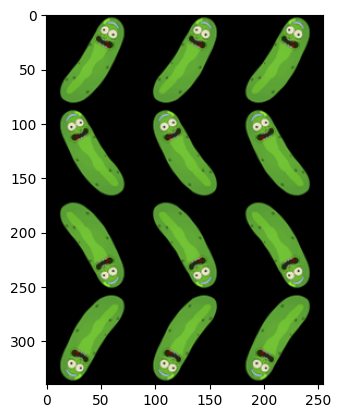

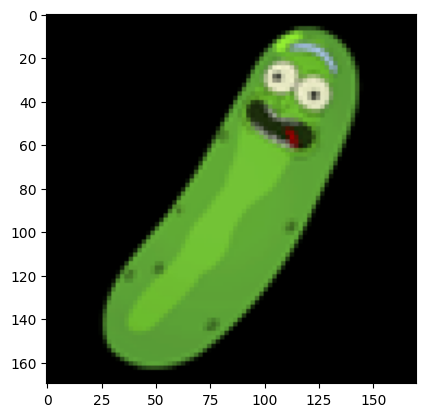

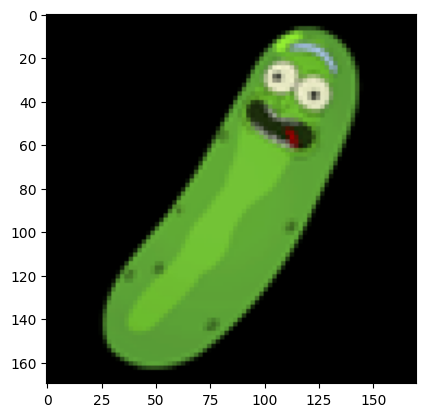

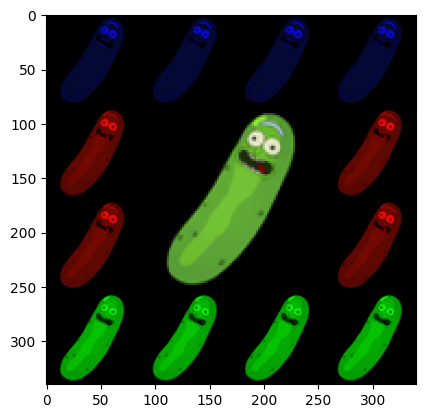

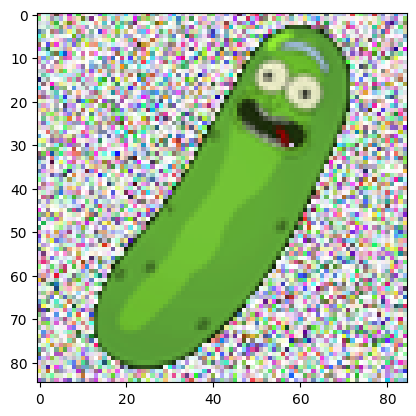

Correct !!!!!


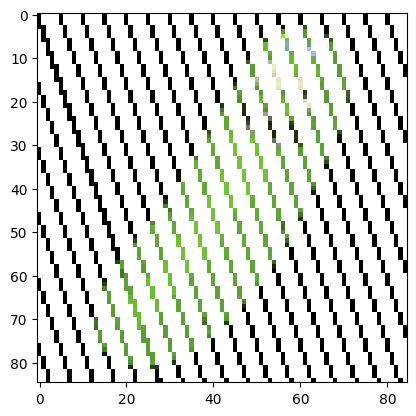

Correct !!!!!


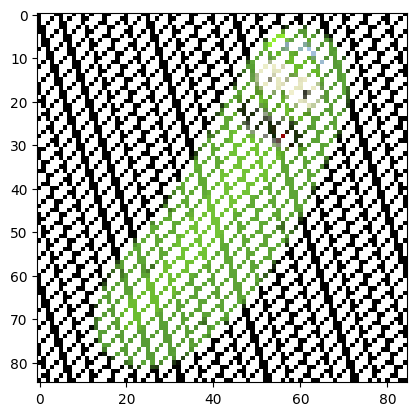

Correct !!!!!


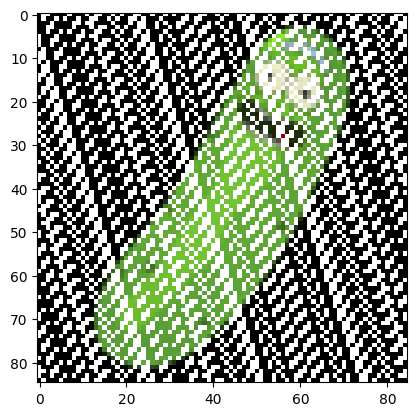

Correct !!!!!


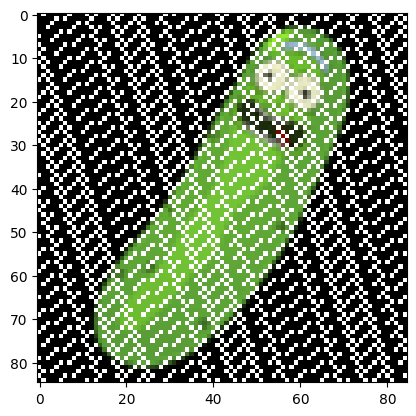

Correct !!!!!
Je had 5 vragen correct en 0 fout beantwoord. Zie hieronder het eindresultaat


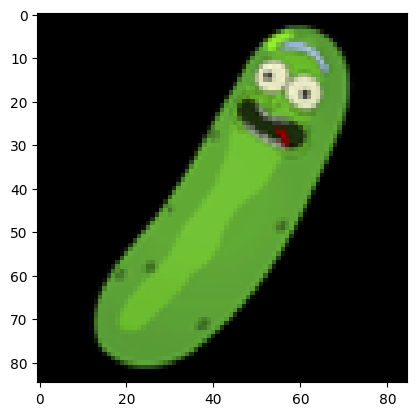

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os
from random import random , randint

def prepare_image():
    loc_input_img = os.path.join('13 - Assignment','opdracht_image_manipulation','image_raw.png')
    # Open the image and convert it to a NumPy array
    i = Image.open(loc_input_img)
    np_image_original = np.array(i)
    np_image_resized = np_image_original[12:97, 22:107]
    return np_image_resized

def display_image(image, show_axis=True):
    plt.imshow(image)
    if (not show_axis):
        plt.axis('off') 
    plt.show()
    
def resize_image_by_factor(image, factor):
    stretched_horizontal = np.repeat(image, factor, axis=0)
    stretched_horizontal_vertical = np.repeat(stretched_horizontal, factor, axis=1)
    return stretched_horizontal_vertical

def resize_image_by_factor_manual_way(image, factor):
    
    row, columns, rgb = image.shape
    
    new_result_by_factor = []
    
    # dupplicate columns and rows
    for row_index in range(row):
        new_row_by_factor = []
        for column_index in range(columns):
            for repetition in range(factor):
                new_row_by_factor.append(image[row_index][column_index])
        for repetition in range(factor):
            new_result_by_factor.append(new_row_by_factor)
    return np.array(new_result_by_factor)

def flip_left_right(image):
    return image[::, ::-1]

def flip_upside_down(image):
    return image[::-1]

def grid_with_flips(image = prepare_image(), matrix = np.repeat(np.arange(4).reshape(4,1),7,axis=1)):
    """
    Creates raster of an image. Raster inResizes the image manually by duplicating rows and columns based on the given factor.

    Args:
        image (np.ndarray): The original image as a NumPy array.
        matrix (np.ndarray): A matrix with numeric values that correspond to the flip. 
        0 for you image not flipped, 1 for flipping your image left right, 2 for flipping it upside down and 3 for flipping it both left right and upside down

    Returns:
        np.ndarray: The resized image.
    """
    rows, cols = matrix.shape
    
    raster = []
    
    # fill raster with image objects
    for row in matrix: 
        row_images = []
        for transformation in row:
            if transformation == 1:
                row_images.append(flip_left_right(image))
            elif transformation == 2:
                row_images.append(flip_upside_down(image))
            elif transformation == 3:
                row_images.append(flip_upside_down(flip_left_right(image)))
            else:
                row_images.append(image)
        raster.append(np.hstack(row_images))
    
    return np.vstack(raster)

def change_colorvalue(colorvalue, factor):
    return int(colorvalue*factor)

change_colorvalue_vectorized = np.vectorize(change_colorvalue)

def change_color_image(image, color):
    #gaat de alle kleurkanalen behalve die van parameter color met een bepaalde factor verminderen
    # bv. color='r' -> kanalen blauw en groen worden met 95% verminderd
    colored_image = image.copy()
    redvalue=image[:,:, 0]
    greenvalue=image[:,:, 1]
    bluevalue=image[:,:, 2]
    if color == 'r':
        colored_image[:,:,0] = change_colorvalue_vectorized(redvalue, 1 )
        colored_image[:,:,1] = change_colorvalue_vectorized(greenvalue, 0.05)
        colored_image[:,:,2] = change_colorvalue_vectorized(bluevalue, 0.05)
    elif color == 'g':
        colored_image[:,:,0] = change_colorvalue_vectorized(redvalue, 0.05 )
        colored_image[:,:,1] = change_colorvalue_vectorized(greenvalue, 1)
        colored_image[:,:,2] = change_colorvalue_vectorized(bluevalue, 0.05)
    elif color == 'b':
        colored_image[:,:,0] = change_colorvalue_vectorized(redvalue, 0.05 )
        colored_image[:,:,1] = change_colorvalue_vectorized(greenvalue, 0.05)
        colored_image[:,:,2] = change_colorvalue_vectorized(bluevalue, 1)
    return colored_image

def replace_black_with_random_color(image):
    
    # Create a mask for black pixels (threshold for black: RGB <= 30)
    mask = (image[:, :, 0] <= 30) & (image[:, :, 1] <= 30) & (image[:, :, 2] <= 30) # 2D mask (85,85), for each pixel in image


    # Generate random colors for pixel -> R, G, B, transparent (only for black pixels)
    random_colors = np.random.randint(0, 256, size=(np.sum(mask), 4), dtype=np.uint8)

    # Replace black pixels with random colors
    result_image = image.copy()
    result_image[mask] = random_colors # broadcasting van de 4 kanalen met random values in de posities van de mask

    return result_image


def create_colorful_big_one(image, colors = ['b', 'b', 'b', 'b', 'r', 'r', 'g', 'g', 'g', 'g', 'r', 'r']):
    """
    Creates a raster with the big original image with original colors in the middle, surrounded by colored little images. Color is defined by a list of colors, and will be assigned clockwise
    
    Args: 
        colors: list of colors (b for blue, r for red, g for green) 
        
    Returns:
        np.ndarray: The big image, surrounded by colored ones
    """
    
    colors_verify_input = [colors[i] if i < len(colors) else 'x' for i in range(0,12)]
    
    top_row = np.hstack([change_color_image(image, color) for color in colors_verify_input[0:4]])
    
    middle_row_left = np.vstack([change_color_image(image, color) for color in colors_verify_input[10:12]])
    middle_row_right = np.vstack([change_color_image(image, color) for color in colors_verify_input[4:6]])
    
    middle_row = np.hstack([middle_row_left, resize_image_by_factor_manual_way(image, 2), middle_row_right])
    bottom_row = np.hstack([change_color_image(image, color) for color in colors_verify_input[9:5:-1]]) # todo, feitelijk de andere richting
    
    return np.vstack((top_row, middle_row, bottom_row))
    
def release_pixels_cycle(image_covered, image_original, cycle, cycle_count):
    
    volgnummers = np.arange(0,image.shape[0]*image.shape[1],dtype=np.uint8).reshape(image.shape[0], image.shape[1])
    mask = volgnummers % (cycle_count - cycle) == 0
    
    image_covered[mask] = image_original[mask]
    
    return image_covered

def een_spelleke(image, aantal_vragen=5):
    
    image_covered = image.copy()
    image_covered[:,:,:] = 0
    vragenlijst = {"Hoeveel zijden heeft een vierkant": "4",
            "Welk fruit is geel en krom":"banaan",
            "Welk dier zegt 'miauw'?" : "kat",
            "Wat is de kleur van de lucht op een heldere dag?" : "blauw",
            "Hoeveel dagen zitten er in een week" : "7",
            "Hoeveel poten heeft een spin": "8",
            "Welk dier is bekend om zijn lange nek": "giraf",
            "Hoeveel vingers heeft een mens normaalgezien": "10"            
            }
    correct_answers = 0
    for i in range(aantal_vragen):
        vraag = list(vragenlijst.keys())[i]
        user_input = input(f"Vraag {i + 1}/{aantal_vragen}: {vraag} ")
        
        

        if (user_input.lower() == vragenlijst[vraag].lower()):
            print(f"Correct !!!!!")
            image_covered = release_pixels_cycle(image_covered.copy(), image, i, aantal_vragen)
            correct_answers += 1
        else:
            print(f"je antwoord '{user_input}' was fout, het antwoord was {vragenlijst[vraag]}")
            
        if (i == aantal_vragen - 1):
            print(f"Je had {correct_answers} vragen correct en {aantal_vragen - correct_answers} fout beantwoord. Zie hieronder het eindresultaat")

        display_image(image_covered)
        

            
image = prepare_image()

flips = np.array([[0,0,0],[1,1,1],[2,2,2],[3,3,3]])
display_image(grid_with_flips(image, flips))

display_image(resize_image_by_factor(image, 2))
display_image(resize_image_by_factor_manual_way(image, 2))

display_image(create_colorful_big_one(image))

display_image(replace_black_with_random_color(image))

een_spelleke(prepare_image())
